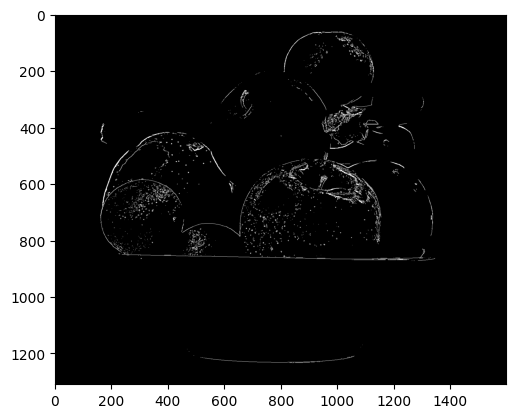

In [159]:
import kornia as k
import torch as t
import matplotlib.pyplot as plt
import numpy as np
from queue import Queue

def MyCanny(img, sd, mt):
    img = plt.imread(img)
    img: t.tensor = k.image_to_tensor(img, keepdim = False).float()

    #grayscale 
    gray = k.color.rgb_to_grayscale(img)
    
    #gaussian blur
    gauss = k.filters.GaussianBlur2d((3, 3), (sd, sd))
    noise: t.tensor = gauss(gray.float())
    
    #gradient magnitude
    xDir = np.array([[-1, 0, 1], 
                     [-2, 0, 2],
                     [-1, 0, 1]])
    
    yDir = np.array([[-1, -2, -1], 
                     [0, 0, 0], 
                     [1, 2, 1]])
    
    kernalX = t.Tensor(xDir).unsqueeze(0).unsqueeze(0)
    kernalY = t.Tensor(yDir).unsqueeze(0).unsqueeze(0)
   
    sobelX = t.conv2d(noise, kernalX)
    sobelY = t.conv2d(noise, kernalY)
     
    mag = t.sqrt(t.square(sobelX) + t.square(sobelY))
    angle = t.rad2deg(t.atan2(sobelY, sobelX))
    
    
    #non max suppression
    maxPix = 225
    for i in range(1, mag.shape[2] - 1):
        for j in range(1, mag.shape[3] - 1):
            #horizontal direction
            if (0 <= angle[:, :, i, j] < 22) or (157 <= angle[:, :, i, j] <= 180):
                #if surrounding are brighter, replace, if not set to zero
                maxPix = t.max(mag[:, :, i, j + 1], mag[:, :, i, j - 1])
                    
            #upper right and lower left direction
            elif (22 <= angle[:, :, i, j] < 67):
                maxPix = t.max(mag[:, :, i + 1, j + 1], mag[:, :, i - 1, j - 1])

            #upper and lower direction
            elif (67 <= angle[:, :, i, j] < 112):
                maxPix = t.max(mag[:, :, i + 1, j], mag[:, :, i - 1, j])
            
            #upper left, lower right direction
            elif (112 <= angle[:, :, i, j] < 157):
                maxPix = t.max(mag[:, :, i + 1, j - 1], mag[:, :, i - 1, j + 1])
            
            #current pixel is brightest, change in zero tensor
            if (mag[:, :, i, j] < maxPix):
                mag[:, :, i, j] = 0
  
    #magnitude threshold
    nms = mag
    for n in range(1, nms.shape[2] - 1):
        for m in range(1, nms.shape[3] - 1):
            #if pixel is below threshold, set to 0, else 225
            if nms[:, :, n, m] < mt:
                nms[:, :, n, m] = 0
            else:
                nms[:, :, n, m] = 225

   
    #convert back to matrix
    img: t.tensor = k.tensor_to_image(nms)
    plt.imshow(img, cmap = "gray")
    
MyCanny('bowl-of-fruit.jpg', .33, 100)